In [1]:
import warnings
import time
import sys
import datetime
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def preprocessing(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    for col in ['category_3']:
        df[col] = df[col].map({'A':1, 'B':2,'C':3})
    return df

def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (pd.Timestamp('2018-02-01') - df['first_active_month']).dt.days
    return df

In [4]:
# データの読み込み
path_new = '../../../../data/raw/new_merchant_transactions.csv'
path_hist = '../../../../data/raw/historical_transactions.csv'
path_train = '../../../../data/raw/train.csv'
path_test = '../../../../data/raw/test.csv'

new = pd.read_csv(path_new, parse_dates=['purchase_date'])
hist = pd.read_csv(path_hist ,parse_dates=['purchase_date'])

new = preprocessing(new)
hist = preprocessing(hist)

new = reduce_mem_usage(new)
hist = reduce_mem_usage(hist)

train = pd.read_csv(path_train, parse_dates=['first_active_month'])
test = pd.read_csv(path_test, parse_dates=['first_active_month'])

target = train['target']
#del train['target']

Mem. usage decreased to 76.76 Mb (63.4% reduction)
Mem. usage decreased to 1193.84 Mb (61.6% reduction)


In [5]:
# データの読み込み
path_train_prepro = '../../../../data/processed/train_processed_0618.csv'
train = pd.read_csv(path_train_prepro)
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'elapsed_time', 'hist_frequency', 'hist_amount_total',
       'hist_amount_mean', 'hist_merchant_category_nu',
       'hist_merchant_category_mode', 'hist_city_nu', 'hist_city_mode',
       'hist_state_nu', 'hist_state_mode', 'hist_date_min', 'hist_date_max',
       'hist_installments_mean', 'hist_installments_max',
       'hist_installments_min', 'hist_month_lag_mean', 'hist_month_lag_max',
       'hist_month_lag_min', 'hist_category_1_mod', 'hist_category_2_mod',
       'hist_category_3_mod', 'hist_ratio_No', 'hist_ratio_Yes',
       'hist_count_No', 'hist_count_Yes', 'hist_duration'],
      dtype='object')

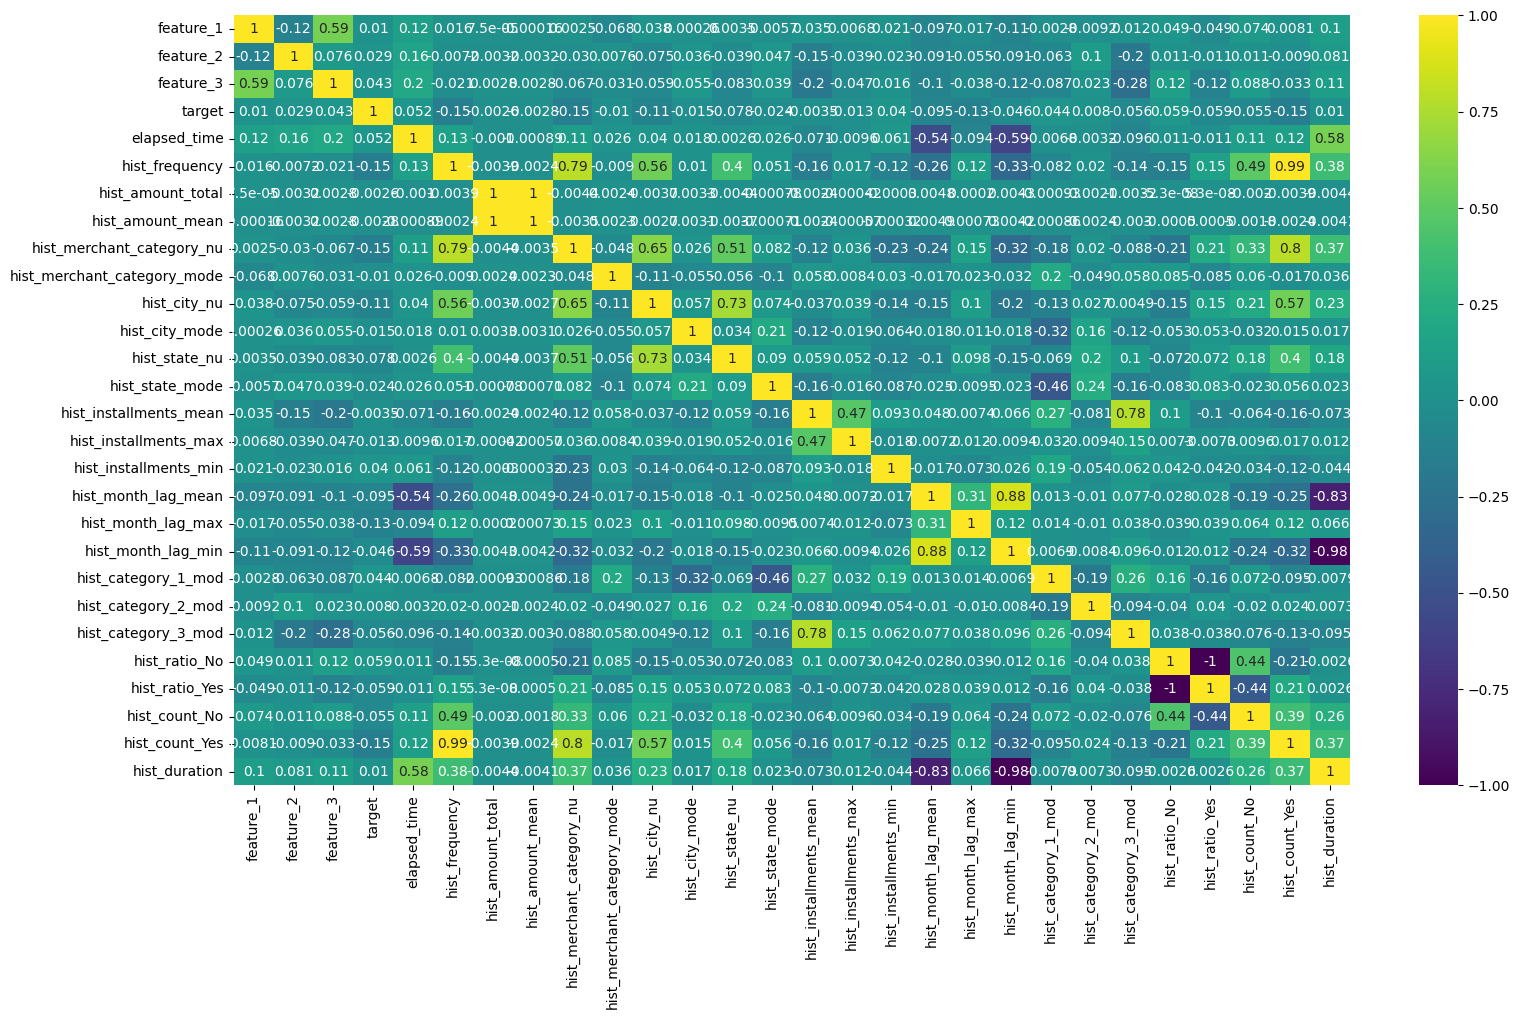

In [28]:
corr = train.drop(columns={'first_active_month','card_id','hist_date_min','hist_date_max'}).query('target>0').reset_index(drop=True).corr() #.
palette = sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(18,10))
sns.heatmap(corr,annot=True,cmap= palette)
plt.show()

In [18]:
train.query('target<-33').target.unique()

array([-33.21928095])

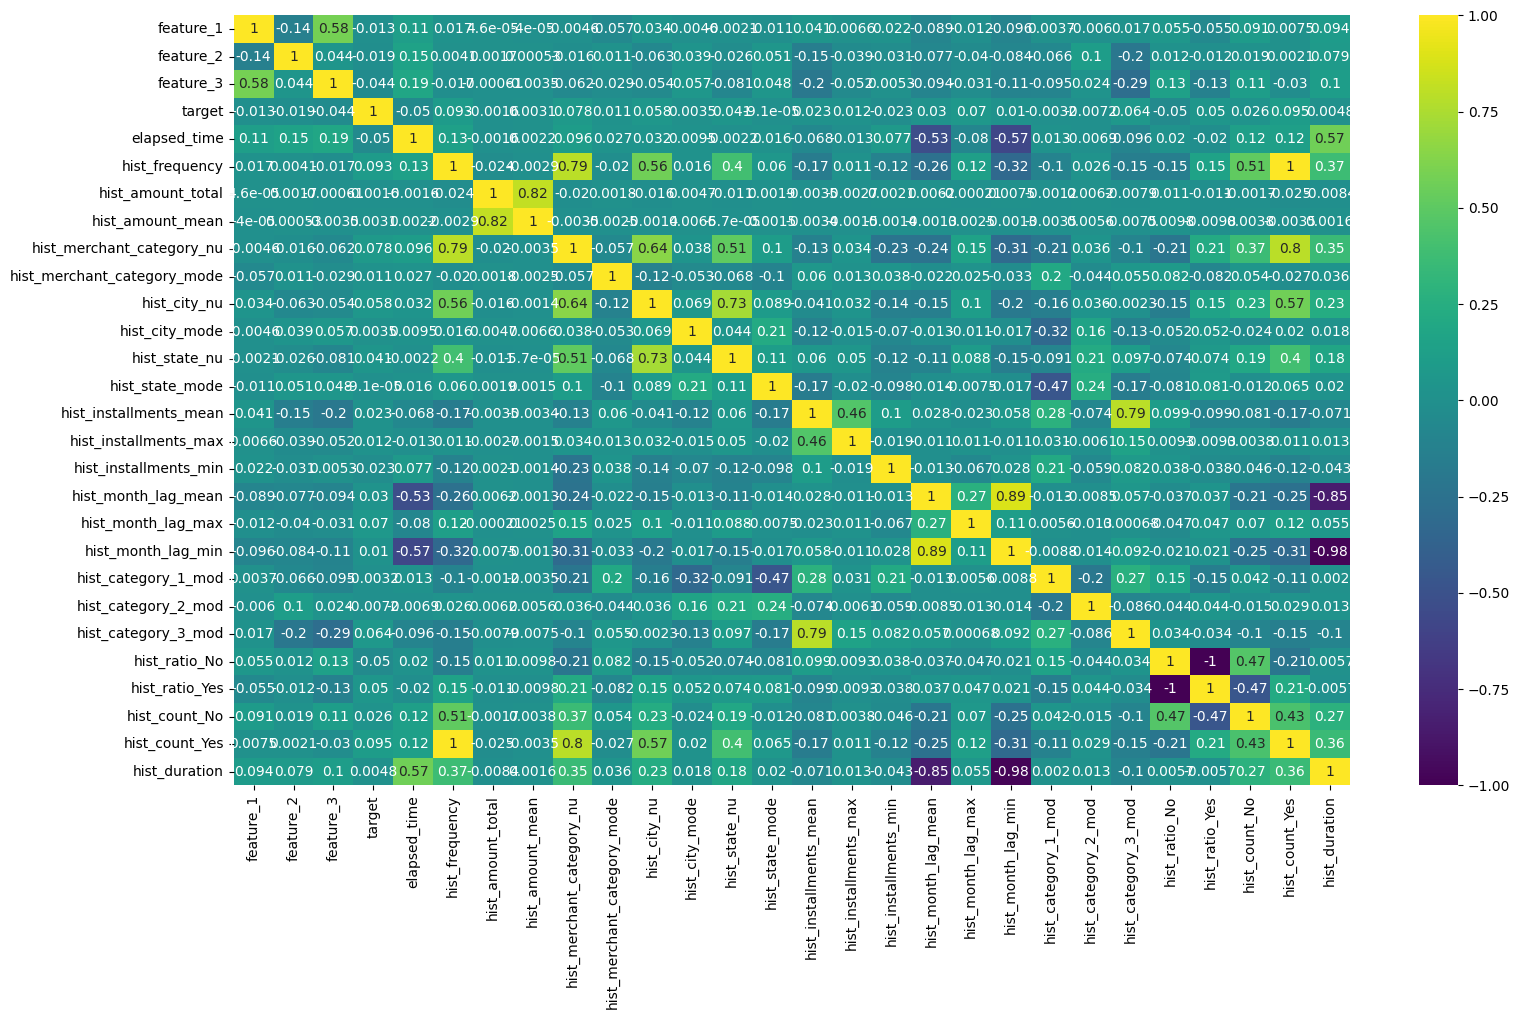

In [21]:
corr2 = train.drop(columns={'first_active_month','card_id','hist_date_min','hist_date_max'}).query('0>=target>-33').reset_index(drop=True).corr() #.
palette = sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(18,10))
sns.heatmap(corr2,annot=True,cmap= palette)
plt.show()

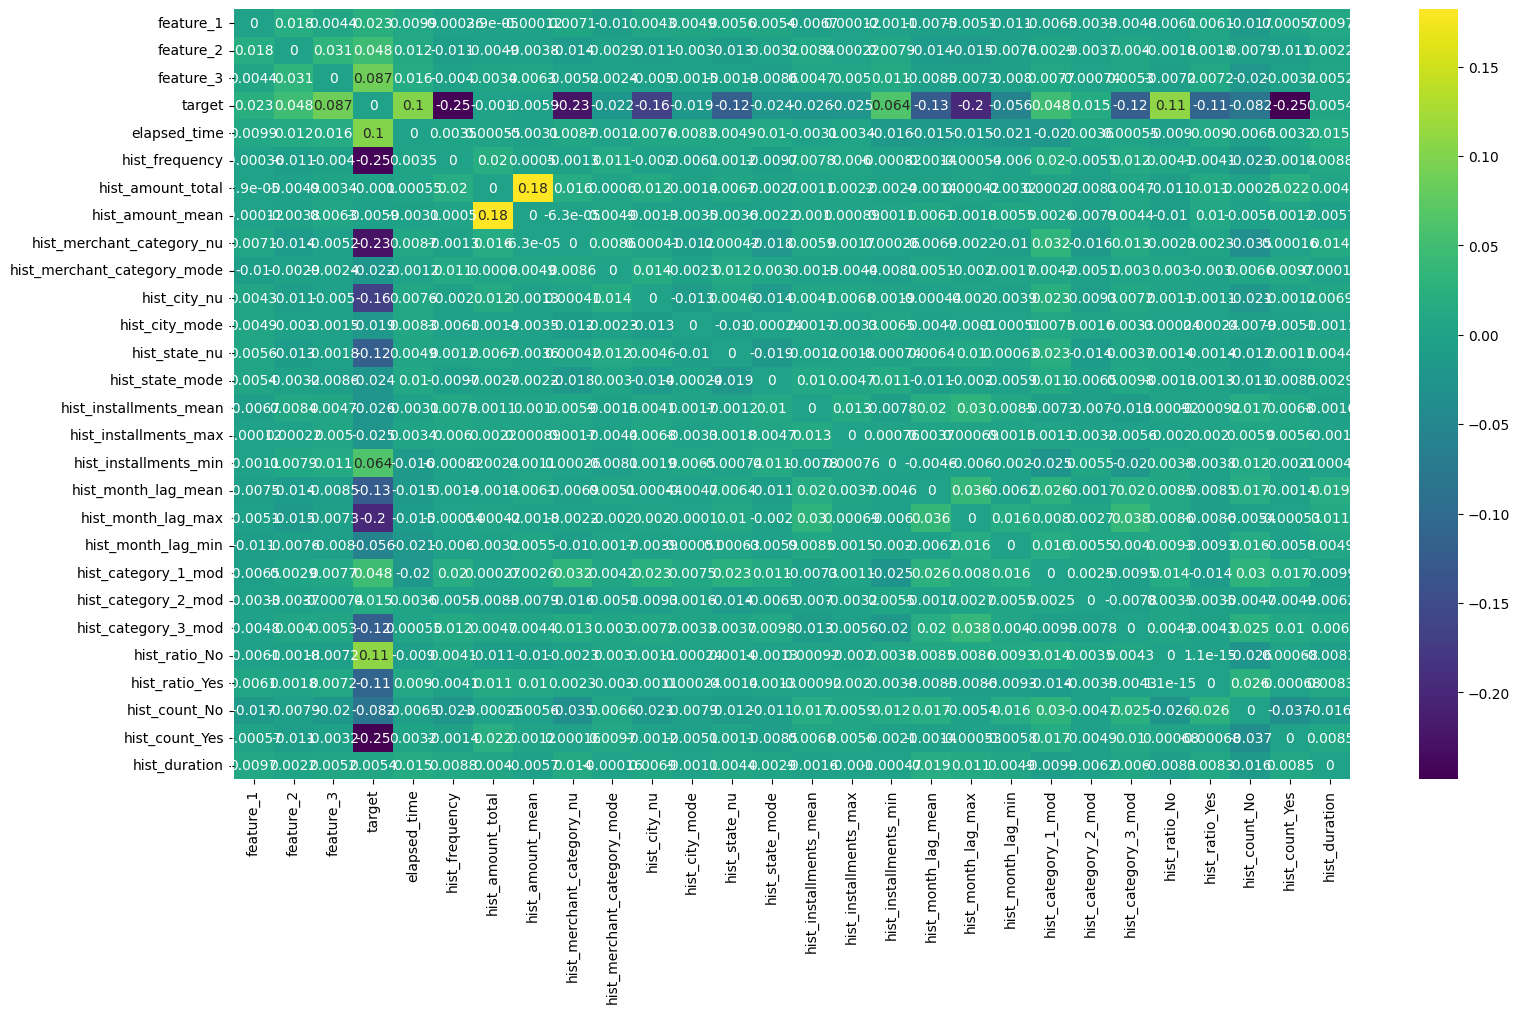

In [29]:
corr - corr2
palette = sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(18,10))
sns.heatmap(corr-corr2,annot=True,cmap= palette)
plt.show()